In [1]:
import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

<Client: 'tcp://203.247.189.224:34221' processes=5 threads=90, memory=419.10 GiB>

# Load modules

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp
import xcesm

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [4]:
# cfg_var_photoC_TOT_zint_100m=CESM2_config()
# cfg_var_photoC_TOT_zint_100m.year_s=1850
# cfg_var_photoC_TOT_zint_100m.year_e=2024
# cfg_var_photoC_TOT_zint_100m.setvar('photoC_TOT_zint_100m')

cfg_var_photoC_diat_zint_100m=CESM2_config()
cfg_var_photoC_diat_zint_100m.year_s=1850
cfg_var_photoC_diat_zint_100m.year_e=2024
cfg_var_photoC_diat_zint_100m.setvar('photoC_diat_zint_100m')


cfg_var_photoC_diaz_zint_100m=CESM2_config()
cfg_var_photoC_diaz_zint_100m.year_s=1850
cfg_var_photoC_diaz_zint_100m.year_e=2024
cfg_var_photoC_diaz_zint_100m.setvar('photoC_diaz_zint_100m')


cfg_var_photoC_sp_zint_100m=CESM2_config()
cfg_var_photoC_sp_zint_100m.year_s=1850
cfg_var_photoC_sp_zint_100m.year_e=2024
cfg_var_photoC_sp_zint_100m.setvar('photoC_sp_zint_100m')


if cfg_var_photoC_diat_zint_100m.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')



In [5]:
cut_grid_info = {
    "lonw": 210,
    "lone": 270,
    "lats": -20,
    "latn": 10
}

# Read files

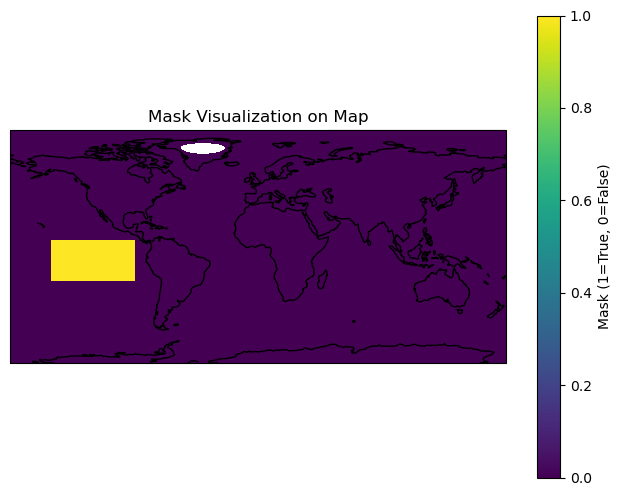

In [6]:
ds=ds_grid
mask = ((ds.TLONG >= cut_grid_info["lonw"]) 
        & (ds.TLONG <= cut_grid_info["lone"]) 
        & (ds.TLAT >= cut_grid_info["lats"]) 
        & (ds.TLAT <= cut_grid_info["latn"]))
iy, ix = np.where(mask)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8, 6))

# mask를 1/0으로 변환한 뒤 지도 위에 겹쳐서 표시
pc = ax.pcolormesh(ds.TLONG, ds.TLAT, mask.astype(int),
                   transform=ccrs.PlateCarree(),
                   cmap='viridis')

ax.coastlines()
plt.colorbar(pc, ax=ax, label='Mask (1=True, 0=False)')
plt.title('Mask Visualization on Map')
plt.show()

In [8]:
# define preprocessing function

ds_grid_sub = ds_grid.where(mask, drop=True)
area = ds_grid_sub['TAREA']
weighted_avg_manual = xr.Dataset()

# data = cfg_var_NO3.LE_ds['NO3']
# weighted_sum = (data * area).sum(dim=['nlat','nlon'], skipna=True)
# effective_area = area.where(data.notnull()).sum(dim=['nlat','nlon'], skipna=True)
# weighted_avg_manual['NO3'] = weighted_sum / effective_area



exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_photoC_diat_zint_100m.var, 
          cfg_var_photoC_diaz_zint_100m.var, cfg_var_photoC_sp_zint_100m.var ]

def process_coords(varname, mask, ds_grid_sub, ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    ds = ds.where(mask, drop=True)
    ds= ds.isel(z_t=slice(0, 1))

    # area = ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * area).sum(dim=['nlat','nlon'], skipna=True)
    # effective_area = area.where(ds[varname].notnull()).sum(dim=['nlat','nlon'], skipna=True)
    # ds[varname] = weighted_sum / effective_area
    
    volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    ds[varname] = weighted_sum / effective_volume
    
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        return ds
    else:
        return ds.set_coords(coord_vars)


def process_coords_obs(ds, drop=True, except_coord_vars=['time','valid_time', 'lon','lat', 'TLONG', 'TLAT', 'sst', 'PP', 'sla', 'SOMXL030', 'NAV_LON', 'NAV_LAT', 'u10', 'v10']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    # ds = ds.where(mask, drop=True)
    # volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # ds[varname] = weighted_sum / effective_volume
    if 'valid_time' in ds:
        ds = ds.rename({'valid_time': 'time'})
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)

start_date = cftime.DatetimeNoLeap(cfg_var_photoC_diat_zint_100m.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_photoC_diat_zint_100m.year_e+1, 1, 1)

In [10]:
# Read LE dataset

start_time = time.time()

# # photoC_TOT_zint_100m
# dname=cfg_var_photoC_TOT_zint_100m.var
# cfg_var_photoC_TOT_zint_100m.LE_path_load(cfg_var_photoC_TOT_zint_100m.var)
# cfg_var_photoC_TOT_zint_100m.LE_ds = xr.open_mfdataset(cfg_var_photoC_TOT_zint_100m.LE_file_list[0], 
#                        chunks={'time': 12}, 
#                        combine='nested', 
#                        concat_dim=[[*cfg_var_photoC_TOT_zint_100m.LE_ensembles], 'time'], 
#                        parallel=True,
#                        preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, start_date, end_date),
#                        decode_cf=True, 
#                        decode_times=True)      

# cfg_var_photoC_TOT_zint_100m.LE_ds = cfg_var_photoC_TOT_zint_100m.LE_ds.rename({"concat_dim": "ens_LE"})
# new_time = cfg_var_photoC_TOT_zint_100m.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_photoC_TOT_zint_100m.LE_ds.time))
# cfg_var_photoC_TOT_zint_100m.LE_ds = cfg_var_photoC_TOT_zint_100m.LE_ds.assign_coords(time=new_time)


# photoC_diat_zint_100m
dname=cfg_var_photoC_diat_zint_100m.var
cfg_var_photoC_diat_zint_100m.LE_path_load(cfg_var_photoC_diat_zint_100m.var)
cfg_var_photoC_diat_zint_100m.LE_ds = xr.open_mfdataset(cfg_var_photoC_diat_zint_100m.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_photoC_diat_zint_100m.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_photoC_diat_zint_100m.LE_ds = cfg_var_photoC_diat_zint_100m.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_photoC_diat_zint_100m.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_photoC_diat_zint_100m.LE_ds.time))
cfg_var_photoC_diat_zint_100m.LE_ds = cfg_var_photoC_diat_zint_100m.LE_ds.assign_coords(time=new_time)


# photoC_diaz_zint_100m
dname=cfg_var_photoC_diaz_zint_100m.var
cfg_var_photoC_diaz_zint_100m.LE_path_load(cfg_var_photoC_diaz_zint_100m.var)
cfg_var_photoC_diaz_zint_100m.LE_ds = xr.open_mfdataset(cfg_var_photoC_diaz_zint_100m.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_photoC_diaz_zint_100m.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_photoC_diaz_zint_100m.LE_ds = cfg_var_photoC_diaz_zint_100m.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_photoC_diaz_zint_100m.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_photoC_diaz_zint_100m.LE_ds.time))
cfg_var_photoC_diaz_zint_100m.LE_ds = cfg_var_photoC_diaz_zint_100m.LE_ds.assign_coords(time=new_time)


# photoC_sp_zint_100m
dname=cfg_var_photoC_sp_zint_100m.var
cfg_var_photoC_sp_zint_100m.LE_path_load(cfg_var_photoC_sp_zint_100m.var)
cfg_var_photoC_sp_zint_100m.LE_ds = xr.open_mfdataset(cfg_var_photoC_sp_zint_100m.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_photoC_sp_zint_100m.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_photoC_sp_zint_100m.LE_ds = cfg_var_photoC_sp_zint_100m.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_photoC_sp_zint_100m.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_photoC_sp_zint_100m.LE_ds.time))
cfg_var_photoC_sp_zint_100m.LE_ds = cfg_var_photoC_sp_zint_100m.LE_ds.assign_coords(time=new_time)


end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

elasped time for reading LE: 924.4313771724701


In [11]:
start_time = time.time()

comp_dataset=xr.Dataset()
comp_dataset['photoC_diat_zint_100m']= cfg_var_photoC_diat_zint_100m.LE_ds['photoC_diat_zint_100m']
comp_dataset['photoC_diaz_zint_100m']= cfg_var_photoC_diaz_zint_100m.LE_ds['photoC_diaz_zint_100m']
comp_dataset['photoC_sp_zint_100m']= cfg_var_photoC_sp_zint_100m.LE_ds['photoC_sp_zint_100m']

mask = ((ds.TLONG >= cut_grid_info["lonw"]) 
        & (ds.TLONG <= cut_grid_info["lone"]) 
        & (ds.TLAT >= cut_grid_info["lats"]) 
        & (ds.TLAT <= cut_grid_info["latn"]))


filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_LE_PPs_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

if os.path.exists(filename):
    os.remove(filename)
comp_dataset.to_netcdf(filename, mode='w')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for writing netcdf: ' + str(elapsed_time))

elasped time for writing netcdf: 1690.4994492530823


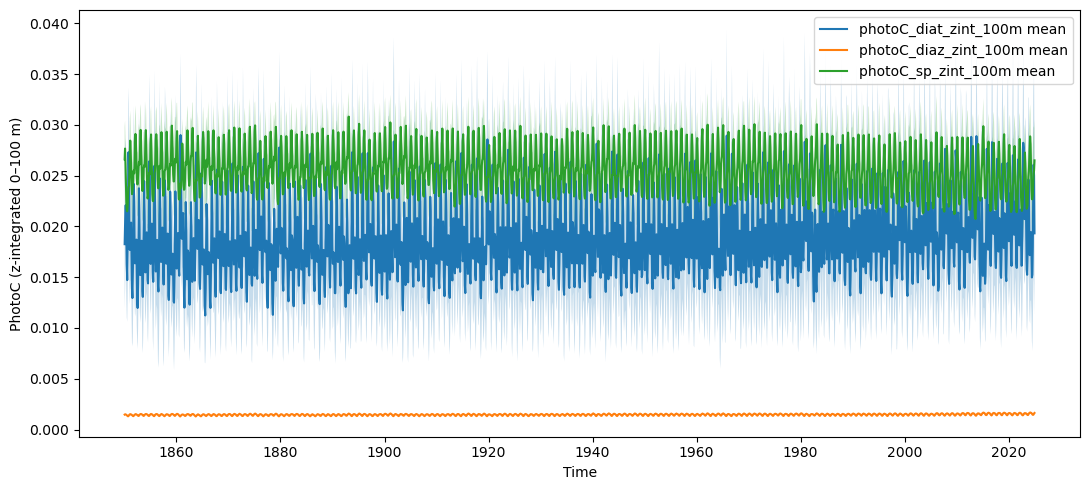

In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd





filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_LE_PPs_"
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

ds = xr.open_dataset(filename)
time_pd = pd.to_datetime(ds['time'].values.astype(str))

vars_photoC = [
    "photoC_diat_zint_100m",
    "photoC_diaz_zint_100m",
    "photoC_sp_zint_100m",
]


plt.figure(figsize=(11,5))

for v in vars_photoC:
    da = ds[v]

    mean = da.mean("ens_LE")
    std  = da.std("ens_LE")

    plt.plot(time_pd, mean, label=f"{v} mean")
    plt.fill_between(
        time_pd,
        mean - std,
        mean + std,
        alpha=0.25
    )

plt.xlabel("Time")
plt.ylabel("PhotoC (z-integrated 0–100 m)")
plt.legend()
plt.tight_layout()
plt.show()



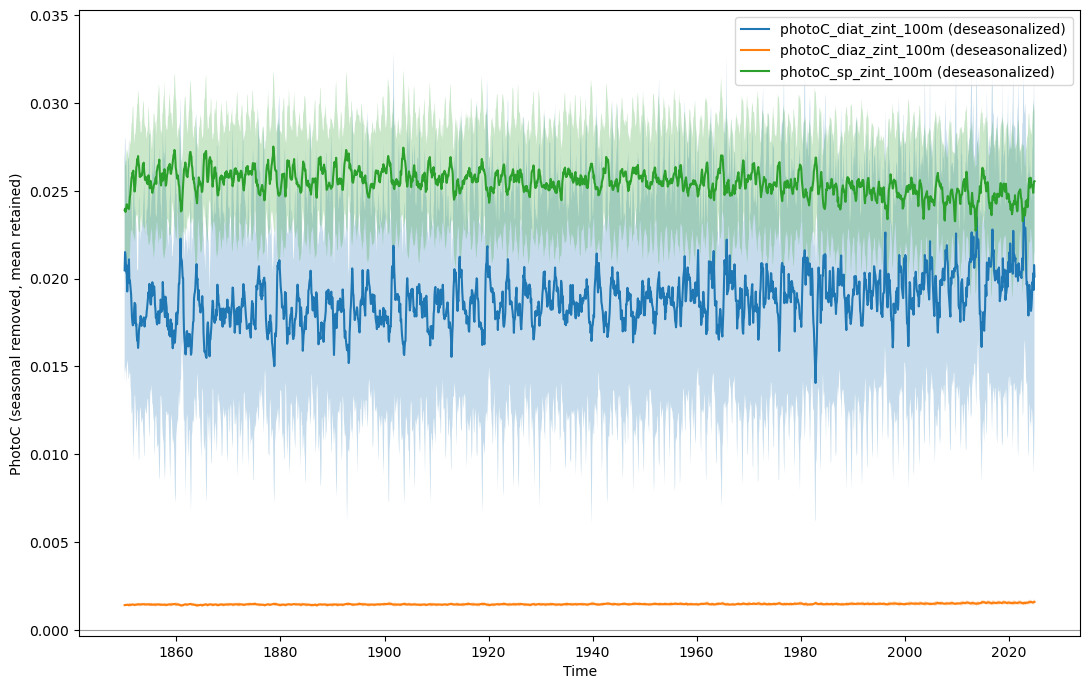

In [21]:
plt.figure(figsize=(11,7))

for v in vars_photoC:
    da = ds[v]   # dims: ens_LE, time

    # 1) Member-wise overall mean (유지할 mean)
    mean_all = da.mean("time")

    # 2) Monthly climatology (mean + seasonal cycle)
    clim = da.groupby("time.month").mean("time")

    # 3) Seasonal-cycle-only component
    seasonal = clim - mean_all

    # 4) Remove ONLY seasonal cycle
    da_deseason = da.groupby("time.month") - seasonal

    # 5) Ensemble statistics
    ens_mean = da_deseason.mean("ens_LE")
    ens_std  = da_deseason.std("ens_LE")

    plt.plot(time_pd, ens_mean, label=f"{v} (deseasonalized)")
    plt.fill_between(
        time_pd,
        ens_mean - ens_std,
        ens_mean + ens_std,
        alpha=0.25
    )

plt.axhline(0, color="k", lw=0.8, alpha=0.4)
plt.xlabel("Time")
plt.ylabel("PhotoC (seasonal removed, mean retained)")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
import numpy as np

std_summary = {}

for v in vars_photoC:
    da = ds[v]

    # ---- deseasonalized but mean-retained ----
    mean_all = da.mean("time")
    clim = da.groupby("time.month").mean("time")
    seasonal = clim - mean_all
    da_deseason = da.groupby("time.month") - seasonal

    # 1) temporal std for each member
    std_time_each = da_deseason.std(dim="time")   # dims: ens_LE

    # 2) ensemble mean of temporal std
    std_ens_mean = std_time_each.mean(dim="ens_LE")

    std_summary[v] = std_ens_mean.item()

std_summary


{'photoC_diat_zint_100m': 0.007074960903439934,
 'photoC_diaz_zint_100m': 9.81682717500616e-05,
 'photoC_sp_zint_100m': 0.0034938695894059816}

In [23]:
cfg_var_photoC_sp_zint_100m